## Appraisal model v.1
appraisal model using xgboost

### Import Libraries and Read preprocessed data

In [10]:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error as MAE 
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import statistics

In [11]:
df = pd.read_csv('../AppraisalDataPreprocessing/preprocessed_data.csv')
df.head(5)

,Id,car_year,model_year_start,model_year_end,mile,cost,car_model,model_3,model_BT-50 PRO,model_CX-3,...,color_brown,color_cream,color_gold,color_gray,color_green,color_other,color_red,color_silver,color_sky,color_white
0,0,-0.680002,-2.014420,-1.817434,0.851441,245000,Mazda 2 1.5 Sports Maxx Sports Hatchback,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,-1.670146,-1.276841,-1.817434,-0.039278,269000,Mazda 3 2.0 Maxx Sports Hatchback,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2,1.300286,0.198318,0.917991,-0.722674,390000,Mazda 2 1.3 S Leather Sedan,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,1.300286,2.042266,0.917991,-0.031599,650000,Mazda CX-30 2.0 SP SUV,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,-0.349954,0.198318,0.917991,1.043406,357900,Mazda 2 1.3 High Connect Sedan,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Appraise cost using xgboost

get mean of each car model for evaluate

In [12]:
df['car_model_mean'] = df['cost'].groupby(df['car_model']).transform(np.mean)

seperate target column from dataframe

In [13]:
X = df.drop(columns=['cost', 'car_model', 'Id'])
y = df['cost']

splitting data  
train : test = 80 : 20  
stratify by car model

In [14]:
car_model = df['car_model']
df.drop(columns=['car_model'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=car_model, random_state=1234)

In [15]:
X_train.drop(columns=['car_model_mean'], inplace=True)
car_model_mean = X_test['car_model_mean']
X_test.drop(columns=['car_model_mean'], inplace=True)

In [16]:
# one2car = pd.read_csv('../AppraisalDataPreprocessing/data_one2car.csv')
# one2car.rename(columns={'Unnamed: 0':'Id'}, inplace=True)
# test = X_test[['Id']].merge(one2car, on='Id')
# test.to_csv('test_dataset.csv')

In [17]:
ttb_id = pd.read_csv('test_dataset_ttb_id.csv')
ttb_bluebook = pd.read_excel('ttb_bluebook.xlsx')
ttb_bluebook.rename(columns={'Unnamed: 0':'ttb_bluebook_id'}, inplace=True)
ttb_id = ttb_id.merge(ttb_bluebook[['avg_used_price', 'ttb_bluebook_id']], how='left', on='ttb_bluebook_id')
ttb_id['avg_used_price'].fillna(value=ttb_id['avg_used_price'].mean(), inplace=True)
estimated_price = ttb_id['avg_used_price']
estimated_price

0       620000.0
1       480000.0
2       525000.0
3      1170000.0
4       235000.0
         ...    
430     430000.0
431     660000.0
432     450000.0
433     235000.0
434     970000.0
Name: avg_used_price, Length: 435, dtype: float64

Use xgboost model to appraise the value

In [18]:
xgb_r = xg.XGBRegressor(objective='reg:squarederror', n_estimators=200, eta=0.05, seed=1234, tree_method="hist", device="cuda", n_jobs=-1, eval_metric="mape")

params = {
    'max_depth': [10, 30, 100],
    'gamma': [0.5, 1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

gs = GridSearchCV(
    estimator = xgb_r,
    param_grid = params,
    verbose=10,
    cv=10,
    n_jobs=-1
)

gs.fit(X_train.to_numpy(), y_train.to_numpy())

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[18:20:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.05,
                                    eval_metric='mape', feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=200,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 2], 'max_depth': [10, 30, 100],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=10)

In [19]:
model = gs.best_estimator_
gs.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='mape',
             feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, ...)

In [20]:
pred = model.predict(X_test)

### Evaluate model

In [21]:
result_cols = ['model', 'mae', 'mse', 'rmse', 'mape', 'r2']
result_df = pd.DataFrame(columns=result_cols)

standard deviation of car price

In [22]:
sd = statistics.stdev(y_test)
print(sd)

185489.10530089893


#### Mean price of each car model

In [23]:
mae = MAE(y_test, car_model_mean)
mse = MSE(y_test, car_model_mean, squared=True)
rmse = MSE(y_test, car_model_mean, squared=False)
mape = MAPE(y_test, car_model_mean)
r2 = r2_score(y_test, car_model_mean)

result = {'model':'mean price', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

#### Estimated price of each car from ttb bluebook

VAT 7% has been included to ttb bluebook estimated price

In [24]:
estimated_price = estimated_price/1.07

In [25]:
mae = MAE(y_test, estimated_price)
mse = MSE(y_test, estimated_price, squared=True)
rmse = MSE(y_test, estimated_price, squared=False)
mape = MAPE(y_test, estimated_price)
r2 = r2_score(y_test, estimated_price)

result = {'model':'ttb bluebook', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

#### XGBoost

In [26]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'xgboost', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [27]:
result_df

,model,mae,mse,rmse,mape,r2
0,mean price,54430.452623,6.043130e+09,77737.574557,0.122708,0.823955
1,ttb bluebook,64602.434698,8.458107e+09,91967.969289,0.151228,0.753603
2,xgboost,37618.143966,3.089913e+09,55586.986553,0.087290,0.909986


In [28]:
import pickle

model_file = open('./models/xgboost.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

### Other model

#### Decision tree

In [29]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(criterion = 'squared_error', random_state=42)

params = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10, 20],
}

gs = GridSearchCV(
    estimator = clf,
    param_grid = params,
    n_jobs=-1,
    verbose=10,
    cv=10
)
gs.fit(X_train, y_train)

model = gs.best_estimator_
gs.best_estimator_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=42)

In [30]:
pred = model.predict(X_test)

In [31]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'decision tree', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [32]:
import pickle

model_file = open('./models/decision_tree.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

#### Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(criterion = 'squared_error', random_state=42)

params = {
    'max_depth': [5, 10]+[None],
    'min_samples_split': [2, 10, 50],
    'n_estimators': [100, 200, 300],
    'max_features': [10, 30, 50, 100, 152],
}

gs = GridSearchCV(
    estimator = clf,
    param_grid = params,
    verbose=10,
    cv=10
)

gs.fit(X_train, y_train)

model = gs.best_estimator_
gs.best_estimator_

Fitting 10 folds for each of 135 candidates, totalling 1350 fits
[CV 1/10; 1/135] START max_depth=5, max_features=10, min_samples_split=2, n_estimators=100


[CV 1/10; 1/135] END max_depth=5, max_features=10, min_samples_split=2, n_estimators=100;, score=0.677 total time=   0.1s
[CV 2/10; 1/135] START max_depth=5, max_features=10, min_samples_split=2, n_estimators=100
[CV 2/10; 1/135] END max_depth=5, max_features=10, min_samples_split=2, n_estimators=100;, score=0.824 total time=   0.1s
[CV 3/10; 1/135] START max_depth=5, max_features=10, min_samples_split=2, n_estimators=100
[CV 3/10; 1/135] END max_depth=5, max_features=10, min_samples_split=2, n_estimators=100;, score=0.837 total time=   0.1s
[CV 4/10; 1/135] START max_depth=5, max_features=10, min_samples_split=2, n_estimators=100
[CV 4/10; 1/135] END max_depth=5, max_features=10, min_samples_split=2, n_estimators=100;, score=0.817 total time=   0.1s
[CV 5/10; 1/135] START max_depth=5, max_features=10, min_samples_split=2, n_estimators=100
[CV 5/10; 1/135] END max_depth=5, max_features=10, min_samples_split=2, n_estimators=100;, score=0.864 total time=   0.1s
[CV 6/10; 1/135] START max

RandomForestRegressor(max_features=10, min_samples_split=10, n_estimators=300,
                      random_state=42)

In [34]:
pred = model.predict(X_test)

In [35]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'random forest', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [36]:
import pickle

model_file = open('./models/random_forest.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

#### XGBoostRFRegressor

In [37]:
xgb_r = xg.XGBRFRegressor(objective='reg:squarederror', n_estimators=200, eta=0.05, seed=1234, tree_method="hist", device="cuda", n_jobs=-1, eval_metric="mape")

params = {
    'max_depth': [10, 30],
    'gamma': [0.5, 1],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0],
}

gs = GridSearchCV(
    estimator = xgb_r,
    param_grid = params,
    verbose=10,
    cv=10,
)

gs.fit(X_train.to_numpy(), y_train.to_numpy())

model = gs.best_estimator_
gs.best_estimator_

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10; 1/16] START colsample_bytree=0.6, gamma=0.5, max_depth=10, subsample=0.6
[18:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



[CV 1/10; 1/16] END colsample_bytree=0.6, gamma=0.5, max_depth=10, subsample=0.6;, score=0.708 total time=   0.6s
[CV 2/10; 1/16] START colsample_bytree=0.6, gamma=0.5, max_depth=10, subsample=0.6
[18:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[CV 2/10; 1/16] END colsample_bytree=0.6, gamma=0.5, max_depth=10, subsample=0.6;, score=0.872 total time=   0.5s
[CV 3/10; 1/16] START colsample_bytree=0.6, gamma=0.5, max_depth=10, subsample=0.6
[18:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[CV 3/10; 1/16] END colsample_bytree=0.6, gamma=0.5, max_depth=10, subsample=0.6;, score=0.926 total time=   0.5s
[CV 4/10; 1/16] START colsample_bytree=0.6, gamma=0.5, max_depth=10, subsample=0.6
[18:44:19] WARNIN

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.6, device='cuda',
               early_stopping_rounds=None, enable_categorical=False, eta=0.05,
               eval_metric='mape', feature_types=None, gamma=0.5, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=200, n_jobs=-1, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, ...)

In [38]:
pred = model.predict(X_test)

In [39]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'xgboostrf', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [40]:
import pickle

model_file = open('./models/xgboostrf.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

#### CatBoost

In [41]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(loss_function='RMSE')

model.fit(X_train, y_train, verbose=100)

Learning rate set to 0.044675
0:	learn: 177382.2217472	total: 77.3ms	remaining: 1m 17s
100:	learn: 60645.3312550	total: 271ms	remaining: 2.41s
200:	learn: 53624.9311865	total: 448ms	remaining: 1.78s
300:	learn: 49702.3315234	total: 615ms	remaining: 1.43s
400:	learn: 47006.2050162	total: 786ms	remaining: 1.17s
500:	learn: 44914.1262838	total: 975ms	remaining: 971ms
600:	learn: 43350.8832313	total: 1.16s	remaining: 768ms
700:	learn: 41776.4249452	total: 1.33s	remaining: 566ms
800:	learn: 40604.9153319	total: 1.5s	remaining: 373ms
900:	learn: 39482.2379805	total: 1.67s	remaining: 184ms
999:	learn: 38626.8337890	total: 1.84s	remaining: 0us


In [42]:
pred = model.predict(X_test)

In [43]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'catboost', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [44]:
import pickle

model_file = open('./models/catboost.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

#### LightGBM

In [47]:
from lightgbm import LGBMRegressor
 
model = LGBMRegressor(metric='mape')
 
model.fit(X_train, y_train)
 
pred = model.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 1737, number of used features: 47
[LightGBM] [Info] Start training from score 451456.712723


In [48]:
pred = model.predict(X_test)

In [49]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'lightgbm', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [50]:
import pickle

model_file = open('./models/lightgbm.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

#### SVR

In [51]:
from sklearn.svm import SVR

svr = SVR()

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'epsilon': [0.1, 0.01, 0.001, 0.0001]  # Epsilon
}


gs = GridSearchCV(
    estimator = svr,
    param_grid = params,
    verbose=10,
    cv=10,
)

gs.fit(X_train.to_numpy(), y_train.to_numpy())

model = gs.best_estimator_
gs.best_estimator_

Fitting 10 folds for each of 384 candidates, totalling 3840 fits
[CV 1/10; 1/384] START C=0.1, epsilon=0.1, gamma=scale, kernel=linear...........
[CV 1/10; 1/384] END C=0.1, epsilon=0.1, gamma=scale, kernel=linear;, score=-0.041 total time=   0.0s
[CV 2/10; 1/384] START C=0.1, epsilon=0.1, gamma=scale, kernel=linear...........
[CV 2/10; 1/384] END C=0.1, epsilon=0.1, gamma=scale, kernel=linear;, score=-0.030 total time=   0.0s
[CV 3/10; 1/384] START C=0.1, epsilon=0.1, gamma=scale, kernel=linear...........
[CV 3/10; 1/384] END C=0.1, epsilon=0.1, gamma=scale, kernel=linear;, score=-0.077 total time=   0.0s
[CV 4/10; 1/384] START C=0.1, epsilon=0.1, gamma=scale, kernel=linear...........
[CV 4/10; 1/384] END C=0.1, epsilon=0.1, gamma=scale, kernel=linear;, score=-0.036 total time=   0.0s
[CV 5/10; 1/384] START C=0.1, epsilon=0.1, gamma=scale, kernel=linear...........
[CV 5/10; 1/384] END C=0.1, epsilon=0.1, gamma=scale, kernel=linear;, score=-0.033 total time=   0.0s
[CV 6/10; 1/384] STA

SVR(C=10, epsilon=0.0001, gamma=1, kernel='poly')

In [52]:
pred = model.predict(X_test)

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [53]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'svr', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [54]:
import pickle

model_file = open('./models/svr.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

#### Linear Regression

In [55]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

params = {
    'fit_intercept': [True, False]
}

gs = GridSearchCV(
    estimator = lr_model,
    param_grid = params,
    verbose=10,
    cv=10,
)

gs.fit(X_train.to_numpy(), y_train.to_numpy())

model = gs.best_estimator_
gs.best_estimator_

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10; 1/2] START fit_intercept=True.........................................
[CV 1/10; 1/2] END ..........fit_intercept=True;, score=0.715 total time=   0.0s
[CV 2/10; 1/2] START fit_intercept=True.........................................
[CV 2/10; 1/2] END ..........fit_intercept=True;, score=0.868 total time=   0.0s
[CV 3/10; 1/2] START fit_intercept=True.........................................
[CV 3/10; 1/2] END ..........fit_intercept=True;, score=0.900 total time=   0.0s
[CV 4/10; 1/2] START fit_intercept=True.........................................
[CV 4/10; 1/2] END ..........fit_intercept=True;, score=0.849 total time=   0.0s
[CV 5/10; 1/2] START fit_intercept=True.........................................
[CV 5/10; 1/2] END ..........fit_intercept=True;, score=0.899 total time=   0.0s
[CV 6/10; 1/2] START fit_intercept=True.........................................
[CV 6/10; 1/2] END ..........fit_intercept=True;

LinearRegression()

In [56]:
pred = model.predict(X_test)

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [57]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'linear regression', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [58]:
import pickle

model_file = open('./models/lr.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

### Lasso

In [59]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()

params = {
    'alpha': [1, 10],
    'fit_intercept': [True, False],
    'tol': [1e-3, 1e-4],
    'selection': ['cyclic', 'random'],
    'max_iter': [500, 1000]
}

gs = GridSearchCV(
    estimator = lasso_model,
    param_grid = params,
    verbose=10,
    cv=10,
)

gs.fit(X_train.to_numpy(), y_train.to_numpy())

model = gs.best_estimator_
gs.best_estimator_

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e+12, tolerance: 5.263e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e+12, tolerance: 5.248e+10
  model = cd_fast.enet_coordinate_descent(


Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV 1/10; 1/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 1/10; 1/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.715 total time=   0.0s
[CV 2/10; 1/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 2/10; 1/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.869 total time=   0.0s
[CV 3/10; 1/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e+12, tolerance: 5.141e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e+12, tolerance: 5.312e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 3/10; 1/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.902 total time=   0.0s
[CV 4/10; 1/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 4/10; 1/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.849 total time=   0.0s
[CV 5/10; 1/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 5/10; 1/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.899 total time=   0.0s
[CV 6/10; 1/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 6/10; 1/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.918 total time=   0.0s
[CV 7/10; 1/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.268e+12, tolerance: 5.191e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e+12, tolerance: 5.218e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 7/10; 1/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.907 total time=   0.0s
[CV 8/10; 1/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 8/10; 1/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.847 total time=   0.0s
[CV 9/10; 1/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 9/10; 1/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.903 total time=   0.0s
[CV 10/10; 1/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 10/10; 1/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.872 total time=   0.0s
[CV 1/10; 2/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e+12, tolerance: 5.263e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e+12, tolerance: 5.248e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 1/10; 2/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.715 total time=   0.0s
[CV 2/10; 2/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001
[CV 2/10; 2/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.869 total time=   0.0s
[CV 3/10; 2/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001
[CV 3/10; 2/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.902 total time=   0.0s
[CV 4/10; 2/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001
[CV 4/10; 2/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.849 total time=   0.0s
[CV 5/10; 2/32] START alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001
[CV 5/10; 2/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.899 total time=   0.0s

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e+12, tolerance: 5.296e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e+12, tolerance: 5.263e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 10/10; 2/32] END alpha=1, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.872 total time=   0.0s
[CV 1/10; 3/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 1/10; 3/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.715 total time=   0.0s
[CV 2/10; 3/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 2/10; 3/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.869 total time=   0.0s
[CV 3/10; 3/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 3/10; 3/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.901 total time=   0.0s
[CV 4/10; 3/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 4/10; 3/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.850 total time=   0.0s
[CV 5/

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.821e+12, tolerance: 5.191e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.738e+12, tolerance: 5.218e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 7/10; 3/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.907 total time=   0.0s
[CV 8/10; 3/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 8/10; 3/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.847 total time=   0.0s
[CV 9/10; 3/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 9/10; 3/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.903 total time=   0.0s
[CV 10/10; 3/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 10/10; 3/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.872 total time=   0.0s
[CV 1/10; 4/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001
[CV 1/10; 4/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.715 total time=   0.0s
[CV 

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.838e+12, tolerance: 5.376e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.409e+12, tolerance: 5.234e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 5/10; 4/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.899 total time=   0.0s
[CV 6/10; 4/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001
[CV 6/10; 4/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.918 total time=   0.0s
[CV 7/10; 4/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001
[CV 7/10; 4/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.907 total time=   0.0s
[CV 8/10; 4/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001
[CV 8/10; 4/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.847 total time=   0.0s
[CV 9/10; 4/32] START alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001
[CV 9/10; 4/32] END alpha=1, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.903 total time=   0.0s

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.006e+11, tolerance: 5.263e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.311e+11, tolerance: 5.248e+10
  model = cd_fast.enet_coordinate_descent(


[CV 1/10; 5/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.715 total time=   0.0s
[CV 2/10; 5/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001
[CV 2/10; 5/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.869 total time=   0.0s
[CV 3/10; 5/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.618e+11, tolerance: 5.141e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.770e+11, tolerance: 5.312e+10
  model = cd_fast.enet_coordinate_descent(


[CV 3/10; 5/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.902 total time=   0.0s
[CV 4/10; 5/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001
[CV 4/10; 5/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.849 total time=   0.0s
[CV 5/10; 5/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.848e+11, tolerance: 5.376e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.732e+11, tolerance: 5.234e+10
  model = cd_fast.enet_coordinate_descent(


[CV 5/10; 5/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.899 total time=   0.0s
[CV 6/10; 5/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001
[CV 6/10; 5/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.918 total time=   0.0s
[CV 7/10; 5/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.669e+11, tolerance: 5.191e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.491e+11, tolerance: 5.218e+10
  model = cd_fast.enet_coordinate_descent(


[CV 7/10; 5/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.907 total time=   0.0s
[CV 8/10; 5/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001
[CV 8/10; 5/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.847 total time=   0.0s
[CV 9/10; 5/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.005e+11, tolerance: 5.192e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.994e+11, tolerance: 5.296e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 9/10; 5/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.903 total time=   0.0s
[CV 10/10; 5/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001
[CV 10/10; 5/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.872 total time=   0.0s
[CV 1/10; 6/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 1/10; 6/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.715 total time=   0.0s
[CV 2/10; 6/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.311e+11, tolerance: 5.248e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.618e+11, tolerance: 5.141e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 2/10; 6/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.869 total time=   0.0s
[CV 3/10; 6/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 3/10; 6/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.902 total time=   0.0s
[CV 4/10; 6/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 4/10; 6/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.849 total time=   0.0s
[CV 5/10; 6/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 5/10; 6/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.899 total time=   0.0s
[CV 6/10; 6/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 6/10; 6/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.918 total tim

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.669e+11, tolerance: 5.191e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.491e+11, tolerance: 5.218e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 7/10; 6/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.907 total time=   0.0s
[CV 8/10; 6/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 8/10; 6/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.847 total time=   0.0s
[CV 9/10; 6/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 9/10; 6/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.903 total time=   0.0s
[CV 10/10; 6/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 10/10; 6/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.872 total time=   0.0s
[CV 1/10; 7/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 1/10; 7/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.715 total tim

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+12, tolerance: 5.248e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e+12, tolerance: 5.141e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 2/10; 7/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.869 total time=   0.0s
[CV 3/10; 7/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 3/10; 7/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.902 total time=   0.0s
[CV 4/10; 7/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 4/10; 7/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.849 total time=   0.0s
[CV 5/10; 7/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e+12, tolerance: 5.376e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e+12, tolerance: 5.234e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 5/10; 7/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.899 total time=   0.0s
[CV 6/10; 7/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 6/10; 7/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.918 total time=   0.0s
[CV 7/10; 7/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 7/10; 7/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.907 total time=   0.0s
[CV 8/10; 7/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e+12, tolerance: 5.218e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e+12, tolerance: 5.192e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 8/10; 7/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.847 total time=   0.0s
[CV 9/10; 7/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 9/10; 7/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.903 total time=   0.0s
[CV 10/10; 7/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 10/10; 7/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.872 total time=   0.0s
[CV 1/10; 8/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e+12, tolerance: 5.263e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e+12, tolerance: 5.248e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 1/10; 8/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.715 total time=   0.0s
[CV 2/10; 8/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 2/10; 8/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.869 total time=   0.0s
[CV 3/10; 8/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 3/10; 8/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.902 total time=   0.0s
[CV 4/10; 8/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 4/10; 8/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.849 total time=   0.0s
[CV 5/10; 8/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e+12, tolerance: 5.376e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e+12, tolerance: 5.234e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 5/10; 8/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.899 total time=   0.0s
[CV 6/10; 8/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 6/10; 8/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.918 total time=   0.0s
[CV 7/10; 8/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 7/10; 8/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.907 total time=   0.0s
[CV 8/10; 8/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 8/10; 8/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.847 total time=   0.0s
[CV 9/10; 8/32] START alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 9/10; 8/32] END alpha=1, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.903 total tim

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.709e+12, tolerance: 5.296e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+12, tolerance: 3.710e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 3/10; 9/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.896 total time=   0.0s
[CV 4/10; 9/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 4/10; 9/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.845 total time=   0.0s
[CV 5/10; 9/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 5/10; 9/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.898 total time=   0.0s
[CV 6/10; 9/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 6/10; 9/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.911 total time=   0.0s
[CV 7/10; 9/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e+12, tolerance: 3.720e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e+12, tolerance: 3.663e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 7/10; 9/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.895 total time=   0.0s
[CV 8/10; 9/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 8/10; 9/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.837 total time=   0.0s
[CV 9/10; 9/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 9/10; 9/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.901 total time=   0.0s
[CV 10/10; 9/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+12, tolerance: 3.767e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+12, tolerance: 3.710e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 10/10; 9/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.854 total time=   0.0s
[CV 1/10; 10/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 1/10; 10/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.712 total time=   0.0s
[CV 2/10; 10/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 2/10; 10/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.866 total time=   0.0s
[CV 3/10; 10/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 3/10; 10/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.896 total time=   0.0s
[CV 4/10; 10/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 4/10; 10/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.845 t

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e+12, tolerance: 3.735e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e+12, tolerance: 3.712e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 5/10; 10/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.898 total time=   0.0s
[CV 6/10; 10/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 6/10; 10/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.911 total time=   0.0s
[CV 7/10; 10/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 7/10; 10/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.895 total time=   0.0s
[CV 8/10; 10/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 8/10; 10/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.837 total time=   0.0s
[CV 9/10; 10/32] START alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 9/10; 10/32] END alpha=1, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.901 

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.538e+12, tolerance: 3.710e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.651e+12, tolerance: 3.717e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 1/10; 11/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.712 total time=   0.0s
[CV 2/10; 11/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 2/10; 11/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.866 total time=   0.0s
[CV 3/10; 11/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 3/10; 11/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.895 total time=   0.0s
[CV 4/10; 11/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 4/10; 11/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.846 total time=   0.0s
[CV 5/10; 11/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 5/10; 11/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.898 total tim

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e+12, tolerance: 3.712e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.912e+12, tolerance: 3.720e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 6/10; 11/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.911 total time=   0.0s
[CV 7/10; 11/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 7/10; 11/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.896 total time=   0.0s
[CV 8/10; 11/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 8/10; 11/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.837 total time=   0.0s
[CV 9/10; 11/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 9/10; 11/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.901 total time=   0.0s
[CV 10/10; 11/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 10/10; 11/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.855 total t

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.041e+12, tolerance: 3.670e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.817e+12, tolerance: 3.723e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 3/10; 12/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.0001;, score=0.895 total time=   0.0s
[CV 4/10; 12/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.0001
[CV 4/10; 12/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.0001;, score=0.846 total time=   0.0s
[CV 5/10; 12/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.0001
[CV 5/10; 12/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.0001;, score=0.898 total time=   0.0s
[CV 6/10; 12/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.0001
[CV 6/10; 12/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.0001;, score=0.911 total time=   0.0s
[CV 7/10; 12/32] START alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.0001
[CV 7/10; 12/32] END alpha=1, fit_intercept=False, max_iter=500, selection=random, tol=0.0001;, score=0.895 

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.109e+12, tolerance: 3.710e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e+12, tolerance: 3.717e+11
  model = cd_fast.enet_coordinate_descent(


[CV 1/10; 13/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001;, score=0.712 total time=   0.1s
[CV 2/10; 13/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001
[CV 2/10; 13/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001;, score=0.866 total time=   0.0s
[CV 3/10; 13/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e+12, tolerance: 3.670e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+12, tolerance: 3.723e+11
  model = cd_fast.enet_coordinate_descent(


[CV 3/10; 13/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001;, score=0.896 total time=   0.0s
[CV 4/10; 13/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001
[CV 4/10; 13/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001;, score=0.845 total time=   0.0s
[CV 5/10; 13/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.290e+12, tolerance: 3.735e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e+12, tolerance: 3.712e+11
  model = cd_fast.enet_coordinate_descent(


[CV 5/10; 13/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001;, score=0.898 total time=   0.0s
[CV 6/10; 13/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001
[CV 6/10; 13/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001;, score=0.911 total time=   0.0s
[CV 7/10; 13/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e+12, tolerance: 3.720e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e+12, tolerance: 3.663e+11
  model = cd_fast.enet_coordinate_descent(


[CV 7/10; 13/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001;, score=0.895 total time=   0.0s
[CV 8/10; 13/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001
[CV 8/10; 13/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001;, score=0.837 total time=   0.0s
[CV 9/10; 13/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.285e+12, tolerance: 3.693e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e+12, tolerance: 3.767e+11
  model = cd_fast.enet_coordinate_descent(


[CV 9/10; 13/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001;, score=0.901 total time=   0.0s
[CV 10/10; 13/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001
[CV 10/10; 13/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.001;, score=0.854 total time=   0.0s
[CV 1/10; 14/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.109e+12, tolerance: 3.710e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e+12, tolerance: 3.717e+10
  model = cd_fast.enet_coordinate_descent(


[CV 1/10; 14/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.712 total time=   0.0s
[CV 2/10; 14/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001
[CV 2/10; 14/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.866 total time=   0.0s
[CV 3/10; 14/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e+12, tolerance: 3.670e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+12, tolerance: 3.723e+10
  model = cd_fast.enet_coordinate_descent(


[CV 3/10; 14/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.896 total time=   0.0s
[CV 4/10; 14/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001
[CV 4/10; 14/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.845 total time=   0.0s
[CV 5/10; 14/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.290e+12, tolerance: 3.735e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e+12, tolerance: 3.712e+10
  model = cd_fast.enet_coordinate_descent(


[CV 5/10; 14/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.898 total time=   0.0s
[CV 6/10; 14/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001
[CV 6/10; 14/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.911 total time=   0.0s
[CV 7/10; 14/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e+12, tolerance: 3.720e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e+12, tolerance: 3.663e+10
  model = cd_fast.enet_coordinate_descent(


[CV 7/10; 14/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.895 total time=   0.0s
[CV 8/10; 14/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001
[CV 8/10; 14/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.837 total time=   0.0s
[CV 9/10; 14/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.285e+12, tolerance: 3.693e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e+12, tolerance: 3.767e+10
  model = cd_fast.enet_coordinate_descent(


[CV 9/10; 14/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.901 total time=   0.0s
[CV 10/10; 14/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001
[CV 10/10; 14/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.854 total time=   0.0s
[CV 1/10; 15/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e+12, tolerance: 3.710e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e+12, tolerance: 3.717e+11
  model = cd_fast.enet_coordinate_descent(


[CV 1/10; 15/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.712 total time=   0.0s
[CV 2/10; 15/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001
[CV 2/10; 15/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.866 total time=   0.0s
[CV 3/10; 15/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+12, tolerance: 3.670e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.296e+12, tolerance: 3.723e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 3/10; 15/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.896 total time=   0.0s
[CV 4/10; 15/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001
[CV 4/10; 15/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.846 total time=   0.0s
[CV 5/10; 15/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001
[CV 5/10; 15/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.898 total time=   0.0s
[CV 6/10; 15/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.334e+12, tolerance: 3.712e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e+12, tolerance: 3.720e+11
  model = cd_fast.enet_coordinate_descent(


[CV 6/10; 15/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.911 total time=   0.0s
[CV 7/10; 15/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001
[CV 7/10; 15/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.895 total time=   0.0s
[CV 8/10; 15/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.092e+12, tolerance: 3.663e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e+12, tolerance: 3.693e+11
  model = cd_fast.enet_coordinate_descent(


[CV 8/10; 15/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.837 total time=   0.0s
[CV 9/10; 15/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001
[CV 9/10; 15/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.901 total time=   0.0s
[CV 10/10; 15/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.276e+12, tolerance: 3.767e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.403e+11, tolerance: 3.710e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 10/10; 15/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.854 total time=   0.0s
[CV 1/10; 16/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 1/10; 16/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.712 total time=   0.0s
[CV 2/10; 16/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 2/10; 16/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.866 total time=   0.0s
[CV 3/10; 16/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 3/10; 16/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.896 total time=   0.0s
[CV 4/10; 16/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 4/10; 16/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, sco

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.566e+12, tolerance: 3.735e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.981e+12, tolerance: 3.712e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 5/10; 16/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.898 total time=   0.0s
[CV 6/10; 16/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 6/10; 16/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.911 total time=   0.0s
[CV 7/10; 16/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 7/10; 16/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.895 total time=   0.0s
[CV 8/10; 16/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 8/10; 16/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.837 total time=   0.0s
[CV 9/10; 16/32] START alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 9/10; 16/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, sco

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+12, tolerance: 3.767e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.636e+11, tolerance: 5.263e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 10/10; 16/32] END alpha=1, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.854 total time=   0.0s
[CV 1/10; 17/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 1/10; 17/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.714 total time=   0.0s
[CV 2/10; 17/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 2/10; 17/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.869 total time=   0.0s
[CV 3/10; 17/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 3/10; 17/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.901 total time=   0.0s
[CV 4/10; 17/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.863e+11, tolerance: 5.312e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.112e+11, tolerance: 5.376e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 4/10; 17/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.851 total time=   0.0s
[CV 5/10; 17/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 5/10; 17/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.900 total time=   0.0s
[CV 6/10; 17/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 6/10; 17/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.919 total time=   0.0s
[CV 7/10; 17/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.531e+11, tolerance: 5.191e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.543e+11, tolerance: 5.218e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 7/10; 17/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.907 total time=   0.0s
[CV 8/10; 17/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 8/10; 17/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.848 total time=   0.0s
[CV 9/10; 17/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 9/10; 17/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.902 total time=   0.0s
[CV 10/10; 17/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001
[CV 10/10; 17/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.001;, score=0.873 total time=   0.0s
[CV 1/10; 18/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.636e+11, tolerance: 5.263e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.013e+11, tolerance: 5.248e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 1/10; 18/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.714 total time=   0.0s
[CV 2/10; 18/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001
[CV 2/10; 18/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.869 total time=   0.0s
[CV 3/10; 18/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001
[CV 3/10; 18/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.901 total time=   0.0s
[CV 4/10; 18/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001
[CV 4/10; 18/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.851 total time=   0.0s
[CV 5/10; 18/32] START alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001
[CV 5/10; 18/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.900 

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.030e+11, tolerance: 5.296e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.001e+12, tolerance: 5.263e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 10/10; 18/32] END alpha=10, fit_intercept=True, max_iter=500, selection=cyclic, tol=0.0001;, score=0.873 total time=   0.0s
[CV 1/10; 19/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 1/10; 19/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.714 total time=   0.0s
[CV 2/10; 19/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 2/10; 19/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.869 total time=   0.0s
[CV 3/10; 19/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 3/10; 19/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.901 total time=   0.0s
[CV 4/10; 19/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 4/10; 19/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.851 total t

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+12, tolerance: 5.234e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+12, tolerance: 5.191e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 6/10; 19/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.919 total time=   0.0s
[CV 7/10; 19/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 7/10; 19/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.907 total time=   0.0s
[CV 8/10; 19/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 8/10; 19/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.848 total time=   0.0s
[CV 9/10; 19/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 9/10; 19/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.902 total time=   0.0s
[CV 10/10; 19/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001
[CV 10/10; 19/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.001;, score=0.873 total t

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+12, tolerance: 5.141e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+12, tolerance: 5.312e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 3/10; 20/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.901 total time=   0.0s
[CV 4/10; 20/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.0001
[CV 4/10; 20/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.851 total time=   0.0s
[CV 5/10; 20/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.0001
[CV 5/10; 20/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.900 total time=   0.0s
[CV 6/10; 20/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.0001
[CV 6/10; 20/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.919 total time=   0.0s
[CV 7/10; 20/32] START alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.0001
[CV 7/10; 20/32] END alpha=10, fit_intercept=True, max_iter=500, selection=random, tol=0.0001;, score=0.907 

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e+11, tolerance: 5.263e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+11, tolerance: 5.248e+10
  model = cd_fast.enet_coordinate_descent(


[CV 1/10; 21/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.714 total time=   0.0s
[CV 2/10; 21/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001
[CV 2/10; 21/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.870 total time=   0.0s
[CV 3/10; 21/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.936e+11, tolerance: 5.141e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.043e+11, tolerance: 5.312e+10
  model = cd_fast.enet_coordinate_descent(


[CV 3/10; 21/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.901 total time=   0.0s
[CV 4/10; 21/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001
[CV 4/10; 21/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.851 total time=   0.0s
[CV 5/10; 21/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.095e+11, tolerance: 5.376e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.578e+11, tolerance: 5.234e+10
  model = cd_fast.enet_coordinate_descent(


[CV 5/10; 21/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.900 total time=   0.0s
[CV 6/10; 21/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001
[CV 6/10; 21/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.919 total time=   0.0s
[CV 7/10; 21/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.262e+11, tolerance: 5.191e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.021e+11, tolerance: 5.218e+10
  model = cd_fast.enet_coordinate_descent(


[CV 7/10; 21/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.907 total time=   0.0s
[CV 8/10; 21/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001
[CV 8/10; 21/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.848 total time=   0.0s
[CV 9/10; 21/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.242e+11, tolerance: 5.192e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.203e+11, tolerance: 5.296e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 9/10; 21/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.902 total time=   0.0s
[CV 10/10; 21/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001
[CV 10/10; 21/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.001;, score=0.873 total time=   0.0s
[CV 1/10; 22/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 1/10; 22/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.714 total time=   0.0s
[CV 2/10; 22/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+11, tolerance: 5.248e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.936e+11, tolerance: 5.141e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 2/10; 22/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.870 total time=   0.0s
[CV 3/10; 22/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 3/10; 22/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.901 total time=   0.0s
[CV 4/10; 22/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 4/10; 22/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.851 total time=   0.0s
[CV 5/10; 22/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 5/10; 22/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.900 total time=   0.0s
[CV 6/10; 22/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 6/10; 22/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, sco

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.021e+11, tolerance: 5.218e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.242e+11, tolerance: 5.192e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 8/10; 22/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.848 total time=   0.0s
[CV 9/10; 22/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 9/10; 22/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.902 total time=   0.0s
[CV 10/10; 22/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001
[CV 10/10; 22/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.873 total time=   0.0s
[CV 1/10; 23/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 1/10; 23/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.714 total time=   0.0s
[CV 2/10; 23/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.272e+11, tolerance: 5.248e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.300e+11, tolerance: 5.141e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 2/10; 23/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.870 total time=   0.0s
[CV 3/10; 23/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 3/10; 23/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.901 total time=   0.0s
[CV 4/10; 23/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 4/10; 23/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.851 total time=   0.0s
[CV 5/10; 23/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e+12, tolerance: 5.376e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.624e+11, tolerance: 5.234e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 5/10; 23/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.900 total time=   0.0s
[CV 6/10; 23/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 6/10; 23/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.919 total time=   0.0s
[CV 7/10; 23/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 7/10; 23/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.907 total time=   0.0s
[CV 8/10; 23/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.761e+11, tolerance: 5.218e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.209e+11, tolerance: 5.192e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 8/10; 23/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.848 total time=   0.0s
[CV 9/10; 23/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 9/10; 23/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.902 total time=   0.0s
[CV 10/10; 23/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001
[CV 10/10; 23/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.001;, score=0.873 total time=   0.0s
[CV 1/10; 24/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.467e+10, tolerance: 5.263e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.918e+11, tolerance: 5.248e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 1/10; 24/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.714 total time=   0.0s
[CV 2/10; 24/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 2/10; 24/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.869 total time=   0.0s
[CV 3/10; 24/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 3/10; 24/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.901 total time=   0.0s
[CV 4/10; 24/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 4/10; 24/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.851 total time=   0.0s
[CV 5/10; 24/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 5/10; 24/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, sco

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+12, tolerance: 5.234e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.258e+11, tolerance: 5.191e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 6/10; 24/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.919 total time=   0.0s
[CV 7/10; 24/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 7/10; 24/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.907 total time=   0.0s
[CV 8/10; 24/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 8/10; 24/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.848 total time=   0.0s
[CV 9/10; 24/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 9/10; 24/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, score=0.902 total time=   0.0s
[CV 10/10; 24/32] START alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001
[CV 10/10; 24/32] END alpha=10, fit_intercept=True, max_iter=1000, selection=random, tol=0.0001;, s

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.755e+11, tolerance: 3.710e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.786e+11, tolerance: 3.717e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 1/10; 25/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.712 total time=   0.0s
[CV 2/10; 25/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 2/10; 25/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.866 total time=   0.0s
[CV 3/10; 25/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 3/10; 25/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.896 total time=   0.0s
[CV 4/10; 25/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 4/10; 25/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.845 total time=   0.0s
[CV 5/10; 25/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.174e+11, tolerance: 3.735e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.977e+11, tolerance: 3.663e+11
  model = cd_fast.enet_coordinate_descent(


[CV 5/10; 25/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.900 total time=   0.0s
[CV 6/10; 25/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 6/10; 25/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.912 total time=   0.0s
[CV 7/10; 25/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 7/10; 25/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.895 total time=   0.0s
[CV 8/10; 25/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 8/10; 25/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.837 total time=   0.0s
[CV 9/10; 25/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001
[CV 9/10; 25/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.001;, score=0.901 

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.324e+11, tolerance: 3.767e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.755e+11, tolerance: 3.710e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 7/10; 26/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.895 total time=   0.0s
[CV 8/10; 26/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 8/10; 26/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.837 total time=   0.0s
[CV 9/10; 26/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 9/10; 26/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.901 total time=   0.0s
[CV 10/10; 26/32] START alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001
[CV 10/10; 26/32] END alpha=10, fit_intercept=False, max_iter=500, selection=cyclic, tol=0.0001;, score=0.855 total time=   0.0s
[CV 1/10; 27/32] START alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 1/10; 27/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, sco

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.324e+11, tolerance: 3.767e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+12, tolerance: 3.710e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 5/10; 27/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.900 total time=   0.0s
[CV 6/10; 27/32] START alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 6/10; 27/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.912 total time=   0.0s
[CV 7/10; 27/32] START alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 7/10; 27/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.895 total time=   0.0s
[CV 8/10; 27/32] START alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 8/10; 27/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.837 total time=   0.0s
[CV 9/10; 27/32] START alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001
[CV 9/10; 27/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.001;, score=0.901 

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+12, tolerance: 3.712e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.147e+12, tolerance: 3.720e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 2/10; 28/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.0001;, score=0.866 total time=   0.0s
[CV 3/10; 28/32] START alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.0001
[CV 3/10; 28/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.0001;, score=0.896 total time=   0.0s
[CV 4/10; 28/32] START alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.0001
[CV 4/10; 28/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.0001;, score=0.845 total time=   0.0s
[CV 5/10; 28/32] START alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.0001
[CV 5/10; 28/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.0001;, score=0.900 total time=   0.0s
[CV 6/10; 28/32] START alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.0001
[CV 6/10; 28/32] END alpha=10, fit_intercept=False, max_iter=500, selection=random, tol=0.0001;, sco

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.248e+11, tolerance: 3.710e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e+11, tolerance: 3.717e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 5/10; 30/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.900 total time=   0.0s
[CV 6/10; 30/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001
[CV 6/10; 30/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.912 total time=   0.0s
[CV 7/10; 30/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001
[CV 7/10; 30/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.895 total time=   0.0s
[CV 8/10; 30/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001
[CV 8/10; 30/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001;, score=0.837 total time=   0.0s
[CV 9/10; 30/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0001
[CV 9/10; 30/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=cyclic, tol=0.0

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.710e+11, tolerance: 3.712e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.404e+11, tolerance: 3.720e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 1/10; 31/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.712 total time=   0.0s
[CV 2/10; 31/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.001
[CV 2/10; 31/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.866 total time=   0.0s
[CV 3/10; 31/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.001
[CV 3/10; 31/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.896 total time=   0.0s
[CV 4/10; 31/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.001
[CV 4/10; 31/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, score=0.846 total time=   0.0s
[CV 5/10; 31/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.001
[CV 5/10; 31/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.001;, sco

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.199e+12, tolerance: 3.710e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.440e+11, tolerance: 3.717e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 3/10; 32/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.896 total time=   0.0s
[CV 4/10; 32/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 4/10; 32/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.845 total time=   0.0s
[CV 5/10; 32/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 5/10; 32/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.900 total time=   0.0s
[CV 6/10; 32/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 6/10; 32/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.912 total time=   0.0s
[CV 7/10; 32/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 7/10; 32/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.281e+11, tolerance: 3.712e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e+12, tolerance: 3.720e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

[CV 8/10; 32/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.837 total time=   0.0s
[CV 9/10; 32/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 9/10; 32/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.901 total time=   0.0s
[CV 10/10; 32/32] START alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001
[CV 10/10; 32/32] END alpha=10, fit_intercept=False, max_iter=1000, selection=random, tol=0.0001;, score=0.855 total time=   0.0s


c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.362e+11, tolerance: 5.831e+10
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=10, tol=0.001)

In [60]:
pred = model.predict(X_test)

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [61]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'lasso', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [62]:
import pickle

model_file = open('./models/lasso.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

### Ridge

In [63]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

params = {
    'alpha': [1, 10],
    'fit_intercept': [True, False],
    'max_iter': [500, 1000, None]
}

gs = GridSearchCV(
    estimator = ridge_model,
    param_grid = params,
    verbose=10,
    cv=10,
)

gs.fit(X_train.to_numpy(), y_train.to_numpy())

model = gs.best_estimator_
gs.best_estimator_

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10; 1/12] START alpha=1, fit_intercept=True, max_iter=500.................
[CV 1/10; 1/12] END alpha=1, fit_intercept=True, max_iter=500;, score=0.711 total time=   0.0s
[CV 2/10; 1/12] START alpha=1, fit_intercept=True, max_iter=500.................
[CV 2/10; 1/12] END alpha=1, fit_intercept=True, max_iter=500;, score=0.875 total time=   0.0s
[CV 3/10; 1/12] START alpha=1, fit_intercept=True, max_iter=500.................
[CV 3/10; 1/12] END alpha=1, fit_intercept=True, max_iter=500;, score=0.902 total time=   0.0s
[CV 4/10; 1/12] START alpha=1, fit_intercept=True, max_iter=500.................
[CV 4/10; 1/12] END alpha=1, fit_intercept=True, max_iter=500;, score=0.853 total time=   0.0s
[CV 5/10; 1/12] START alpha=1, fit_intercept=True, max_iter=500.................
[CV 5/10; 1/12] END alpha=1, fit_intercept=True, max_iter=500;, score=0.903 total time=   0.0s
[CV 6/10; 1/12] START alpha=1, fit_intercept=True, max_it

Ridge(alpha=1, max_iter=500)

In [64]:
pred = model.predict(X_test)

c:\Users\nonew\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [65]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'ridge', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [66]:
import pickle

model_file = open('./models/ridge.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

### ANN

In [278]:
import torch
from torch import nn

class ANN(nn.Module):
    def __init__(self, in_features, hidden=100):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.Linear(hidden, hidden),
            nn.Linear(hidden, hidden),
            nn.Linear(hidden, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

model = ANN(X_train.to_numpy().shape[1])
model = model.to('cuda')

In [279]:
loss_fn = nn.MSELoss()
device = 'cuda'
batch_size = 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=0.5,
    patience=20,
    min_lr=1e-5
)

In [280]:
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data.astype(np.float32))
        self.labels = torch.from_numpy(labels.astype(np.float32))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index].squeeze()
    
train_dataset = Dataset(X_train.to_numpy()[:int(0.8*len(X_train))], y_train.to_numpy()[:int(0.8*len(X_train))])
val_dataset = Dataset(X_train.to_numpy()[int(0.8*len(X_train)):], y_train.to_numpy()[int(0.8*len(X_train)):])
test_dataset = Dataset(X_test.to_numpy(), y_test.to_numpy())

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [281]:
from tqdm.notebook import tqdm

train_losses = []
val_losses = []
learning_rates = []

epochs = 200

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(train_loader):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(val_loader):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])

  0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 1...
Current LR: 0.01
Epoch 1 train loss: 15627529216.0000
Validating epoch 1
Epoch 1 val loss: 5097496064.0000
Training epoch 2...
Current LR: 0.01
Epoch 2 train loss: 7025038336.0000
Validating epoch 2
Epoch 2 val loss: 9301976064.0000
Training epoch 3...
Current LR: 0.01
Epoch 3 train loss: 6177098752.0000
Validating epoch 3
Epoch 3 val loss: 6095054336.0000
Training epoch 4...
Current LR: 0.01
Epoch 4 train loss: 6426517504.0000
Validating epoch 4
Epoch 4 val loss: 18380759040.0000
Training epoch 5...
Current LR: 0.01
Epoch 5 train loss: 6340984832.0000
Validating epoch 5
Epoch 5 val loss: 4282999040.0000
Training epoch 6...
Current LR: 0.01
Epoch 6 train loss: 5881199104.0000
Validating epoch 6
Epoch 6 val loss: 4910598656.0000
Training epoch 7...
Current LR: 0.01
Epoch 7 train loss: 6347940864.0000
Validating epoch 7
Epoch 7 val loss: 6202102784.0000
Training epoch 8...
Current LR: 0.01
Epoch 8 train loss: 6066564608.0000
Validating epoch 8
Epoch 8 val loss: 731305

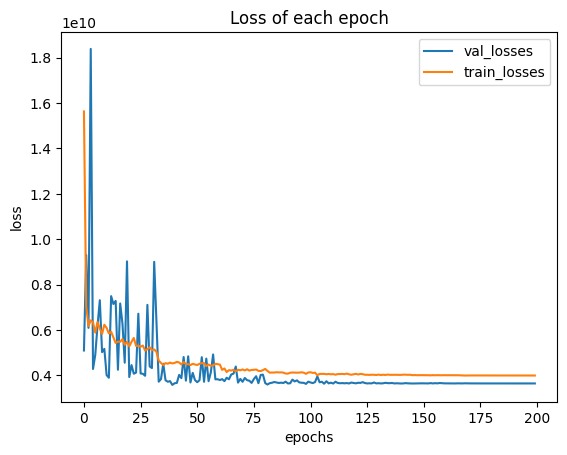

In [282]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses): 
    plt.plot(range(epochs), val_losses, label='val_losses')
    plt.plot(range(epochs), train_losses, label='train_losses')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Loss of each epoch')
    plt.legend()

plot_loss(train_losses, val_losses)

In [283]:
pred = model(torch.from_numpy(X_test.to_numpy().astype(np.float32)).to(device)).squeeze().cpu().detach().numpy()
pred

array([ 510171.5  ,  400053.84 ,  459906.12 ,  735323.8  ,  265083.12 ,
        288920.3  ,  187418.8  ,  619225.75 ,  194843.05 ,  497565.88 ,
        379365.25 ,  619008.25 ,  361111.2  ,  188077.73 ,  313212.1  ,
       1028138.2  ,  338970.28 ,  347357.06 ,  387376.34 ,  163123.72 ,
        415835.8  ,  751175.9  ,  747929.7  ,  371367.22 ,  536497.44 ,
        474507.66 ,  412545.66 ,  206024.9  ,  437058.4  ,  436028.62 ,
        230586.97 ,  249831.56 ,  515701.44 ,  283643.28 ,  396729.7  ,
        583811.94 ,  416285.28 ,  468931.44 ,  286340.88 ,  408785.88 ,
         54237.14 ,  385826.44 ,  454134.53 ,  772484.2  ,  407651.25 ,
        436268.8  ,  399115.47 ,  389529.22 ,  465486.72 ,  351900.53 ,
        844683.2  ,  372430.6  ,  646290.94 ,  441569.34 ,  515701.44 ,
        346253.03 ,  427699.66 ,  375610.9  ,  680305.4  ,  439863.94 ,
        689868.3  ,  436983.1  ,  428967.44 ,  318718.34 ,  519611.66 ,
        266200.34 ,  453078.56 ,  646726.   ,  408831.8  ,  5288

In [286]:
mae = MAE(y_test, pred)
mse = MSE(y_test, pred, squared=True)
rmse = MSE(y_test, pred, squared=False)
mape = MAPE(y_test, pred)
r2 = r2_score(y_test, pred)

result = {'model':'ann', 'mae':mae, 'mse':mse, 'rmse':rmse, 'mape':mape, 'r2':r2}
result_df = pd.concat([result_df, pd.DataFrame([result])], ignore_index=True)

In [288]:
import pickle

model_file = open('./models/ann.model', 'wb')

# Save Decision tree model
pickle.dump(model, model_file)

# Close file
model_file.close()

### Result

In [289]:
result_df

,model,mae,mse,rmse,mape,r2
0,mean price,54430.452623,6.043130e+09,77737.574557,0.122708,0.823955
1,ttb bluebook,64602.434698,8.458107e+09,91967.969289,0.151228,0.753603
2,xgboost,37618.143966,3.089913e+09,55586.986553,0.087290,0.909986
3,decision tree,42038.232399,3.620182e+09,60167.945508,0.095907,0.894539
4,random forest,36168.950302,2.599167e+09,50982.022359,0.083585,0.924282
5,xgboostrf,37062.097342,2.680110e+09,51769.780434,0.086307,0.921924
6,catboost,36567.529046,2.586570e+09,50858.334752,0.085114,0.924649
7,lightgbm,37911.112692,2.799271e+09,52908.140237,0.087894,0.918453
8,svr,60740.141107,1.058592e+10,102887.891508,0.127805,0.691616
9,linear regression,42043.253103,3.232458e+09,56854.705957,0.103647,0.905834


In [290]:
result_df.to_excel('result_v1.xlsx')